In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import defaultdict
import seaborn as sns
sns.set_theme(palette="colorblind")
sns.set_style("white", {'axes.grid': False})

In [ ]:
from src.pv.pv import read_pv_data
from src.observations import minute_observation_stay
from src.pv.metrics import *
from gymportal.evaluation import *
from src.pv.rewards import *
from src.pv.observations import pv_observation_mean
from gymportal.environment import *
from src.pv.pv import read_pv_data
import pytz
from datetime import datetime, timedelta
from gymportal.sim import get_charging_network, Recomputer, EvaluationSimulator, SimGenerator
from gymportal.data.battery_generators import CustomizableBatteryGenerator
from acnportal.acnsim import Linear2StageBattery
from src.rewards import sparse_soc_reward
from src.utils import AV_pod_ids, get_generator, get_power_function

df_pv = read_pv_data("../pv_150kW.csv")
df_pv.describe()

timezone = pytz.timezone("America/Los_Angeles")


charging_network = get_charging_network(
    'simple_acn',
    basic_evse=True,
    voltage=208,
    network_kwargs={
        'station_ids': AV_pod_ids,
        "aggregate_cap": (150 / 54) * len(AV_pod_ids),
    },
)

# charging_network = get_charging_network('caltech', basic_evse=True, voltage=208,
#                                         network_kwargs={"transformer_cap": 150})

battery_generator = CustomizableBatteryGenerator(
    voltage=208,
    period=1,
    battery_types=[
        Linear2StageBattery,
    ],
    max_power_function=get_power_function,
)

# ev_generator = RealWorldGenerator(battery_generator=battery_generator, site='caltech', period=1)
ev_generator = get_generator(
    'caltech',
    "../triple_gmm+sc.pkl",
    battery_generator,
    seed=42,
    frequency_multiplicator=10,
    duration_multiplicator=2,
    file_path="../caltech_2018-03-25 00:00:00-07:53_2020-05-31 00:00:00-07:53_False.csv",
)

observation_objects = [
    charging_rates_observation_normalized(),
    percentage_of_magnitude_observation(),
    diff_pilots_charging_rates_observation_normalized(),
    cyclical_minute_observation(),
    cyclical_day_observation(),
    cyclical_month_observation(),
    minute_observation_stay(),
    energy_delivered_observation_normalized(),
    num_active_stations_observation_normalized(),
    pilot_signals_observation_normalized(),
    pv_observation_mean(df_pv),
]

reward_objects = [
    pv_utilization_reward(df_pv),
    unused_pv_reward(df_pv),
    sparse_soc_reward(),
    # charging_reward(),
]

E0000 00:00:1747649227.517230  902943 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747649227.519943  902943 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
base_config = {
    "observation_objects": observation_objects,
    "action_object": zero_centered_single_charging_schedule_normalized(),
    "reward_objects": reward_objects,
    "meet_constraints": True,
}

start_date = datetime(2019, 1, 1, tzinfo=timezone)
dates = list(
    map(
        lambda x: start_date + timedelta(days=x),
        range(14)
    )
)

configs = [
    base_config | {
        "simgenerator":
            SimGenerator(
                charging_network=charging_network,
                simulation_days=1,
                n_intervals=1,
                start_date=start_date,
                ev_generator=ev_generator,
                recomputer=Recomputer(recompute_interval=10, sparse=True),
                sim_class=EvaluationSimulator,
            )
    } for start_date in dates
]

In [ ]:
# TODO Define metrics (power delivered in kWh, etc.)
#   kWh delivered
#   kWh from PV
#   % of PV used (how much of the PV energy was utilized by charging EVs)
#   kWh from grid
#   SoC => 90%
#   mean / median SoC
#   % of demand met
#   peak demand
from gymportal.evaluation import *
from src.pv.metrics import *

metrics = {
    "SoC >= 90%": percentage_soc,
    "mean SoC": mean_soc,
    "median SoC": median_soc,
    # "pv utilization": lambda sim: pv_utilization_metric(sim, df_pv),
    "grid usage": lambda sim: grid_use_metric(sim, df_pv),
    "unused pv": lambda sim: unused_pv_metric(sim, df_pv),
}

In [ ]:
from gymportal.evaluation import ACNSchedule
from acnportal.algorithms import UncontrolledCharging, SortedSchedulingAlgo, last_come_first_served, \
    first_come_first_served
from evaluation.utils import load_agent
from src.cleanRL.agent import BetaAgent, Agent
from src.cleanRL.scheduler import CleanRLSchedule


def load_agent(x, agent_class=Agent):
    from utils import load_agent as ld
    return ld(x, configs, agent_class=agent_class)


models = {
    "PPO": CleanRLSchedule(load_agent("RL_data/83219666-d196-4bb2-94d1-bf0d56b33df7/RL_454656")),
    "PPO-Beta": CleanRLSchedule(load_agent("RL_data/e6fd5bab-63ad-448d-90e0-842c239a1775/RL_454656", agent_class=BetaAgent)),
    "PPO-SoC": CleanRLSchedule(load_agent("RL_data/9f283b5a-8a3c-43d8-a59e-a574597c3824/RL_606208")),
    "PPO-SoC-Beta": CleanRLSchedule(load_agent("RL_data/6a095390-7c96-4a8c-b678-c161f94f65fb/RL_606208", agent_class=BetaAgent)),
    "FCFS": ACNSchedule(SortedSchedulingAlgo(first_come_first_served)),
    "LCFS": ACNSchedule(SortedSchedulingAlgo(last_come_first_served)),
    "Uncontrolled": ACNSchedule(UncontrolledCharging()),
}

ic| nt = agent_: <class 'src.cleanRL.agent.Agent'>
ic| nt = agent_: <class 'src.cleanRL.agent.BetaAgent'>
ic| nt = agent_: <class 'src.cleanRL.agent.Agent'>
ic| nt = agent_: <class 'src.cleanRL.agent.Agent'>


RuntimeError: Error(s) in loading state_dict for Agent:
	Missing key(s) in state_dict: "actor_logstd", "actor_mean.0.weight", "actor_mean.0.bias", "actor_mean.2.weight", "actor_mean.2.bias", "actor_mean.4.weight", "actor_mean.4.bias", "actor_mean.6.weight", "actor_mean.6.bias". 
	Unexpected key(s) in state_dict: "_actor_base.0.weight", "_actor_base.0.bias", "_actor_base.2.weight", "_actor_base.2.bias", "_actor_base.4.weight", "_actor_base.4.bias", "alpha_head.1.weight", "alpha_head.1.bias", "beta_head.1.weight", "beta_head.1.bias". 

In [ ]:
import torch

# Load the state_dict (this is just a plain dictionary of tensors)
state_dict = torch.load('RL_data/e6fd5bab-63ad-448d-90e0-842c239a1775/RL_454656.mdl', map_location='cpu')  # or GPU if you want

# Print keys and shapes
for key, tensor in state_dict.items():
    print(f"{key}: {tensor.shape}")

critic.0.weight: torch.Size([2048, 49])
critic.0.bias: torch.Size([2048])
critic.2.weight: torch.Size([512, 2048])
critic.2.bias: torch.Size([512])
critic.4.weight: torch.Size([128, 512])
critic.4.bias: torch.Size([128])
critic.6.weight: torch.Size([1, 128])
critic.6.bias: torch.Size([1])
_actor_base.0.weight: torch.Size([2048, 49])
_actor_base.0.bias: torch.Size([2048])
_actor_base.2.weight: torch.Size([512, 2048])
_actor_base.2.bias: torch.Size([512])
_actor_base.4.weight: torch.Size([128, 512])
_actor_base.4.bias: torch.Size([128])
alpha_head.1.weight: torch.Size([8, 128])
alpha_head.1.bias: torch.Size([8])
beta_head.1.weight: torch.Size([8, 128])
beta_head.1.bias: torch.Size([8])


/tmp/ipykernel_900318/219491302.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('RL_data/e6fd5bab-63ad-448d-90e0-842c239a1775/RL_454656.mdl', map

In [ ]:
from src.utils import evaluate_model
from src.cleanRL.environment import make_env

__tuples = {
    model_name: [
        evaluate_model(model,
                       make_env(cfg | {"action_object": single_charging_schedule()} if isinstance(
                           model, ACNSchedule) else cfg, 0.99, 0)(), 93242598,
                       ) for cfg in configs
    ] for model_name, model in models.items()
}

simulations = {
    model_name: [v[0] for v in tuples] for model_name, tuples in __tuples.items()
}

agg_rewards = {
    model_name: [v[1] for v in tuples] for model_name, tuples in __tuples.items()
}


del __tuples

/home/guest/tsturm/acn-experiments/.conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guest/tsturm/acn-experiments/.conda/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/guest/tsturm/acn-experiments/.conda/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
test_statistics = {
    metric_name: {
        model_name: [
            f(sim) for sim in sims
        ] for model_name, sims in simulations.items()
    } for metric_name, f in metrics.items()
} | {"returns": agg_rewards}

# test_statistics

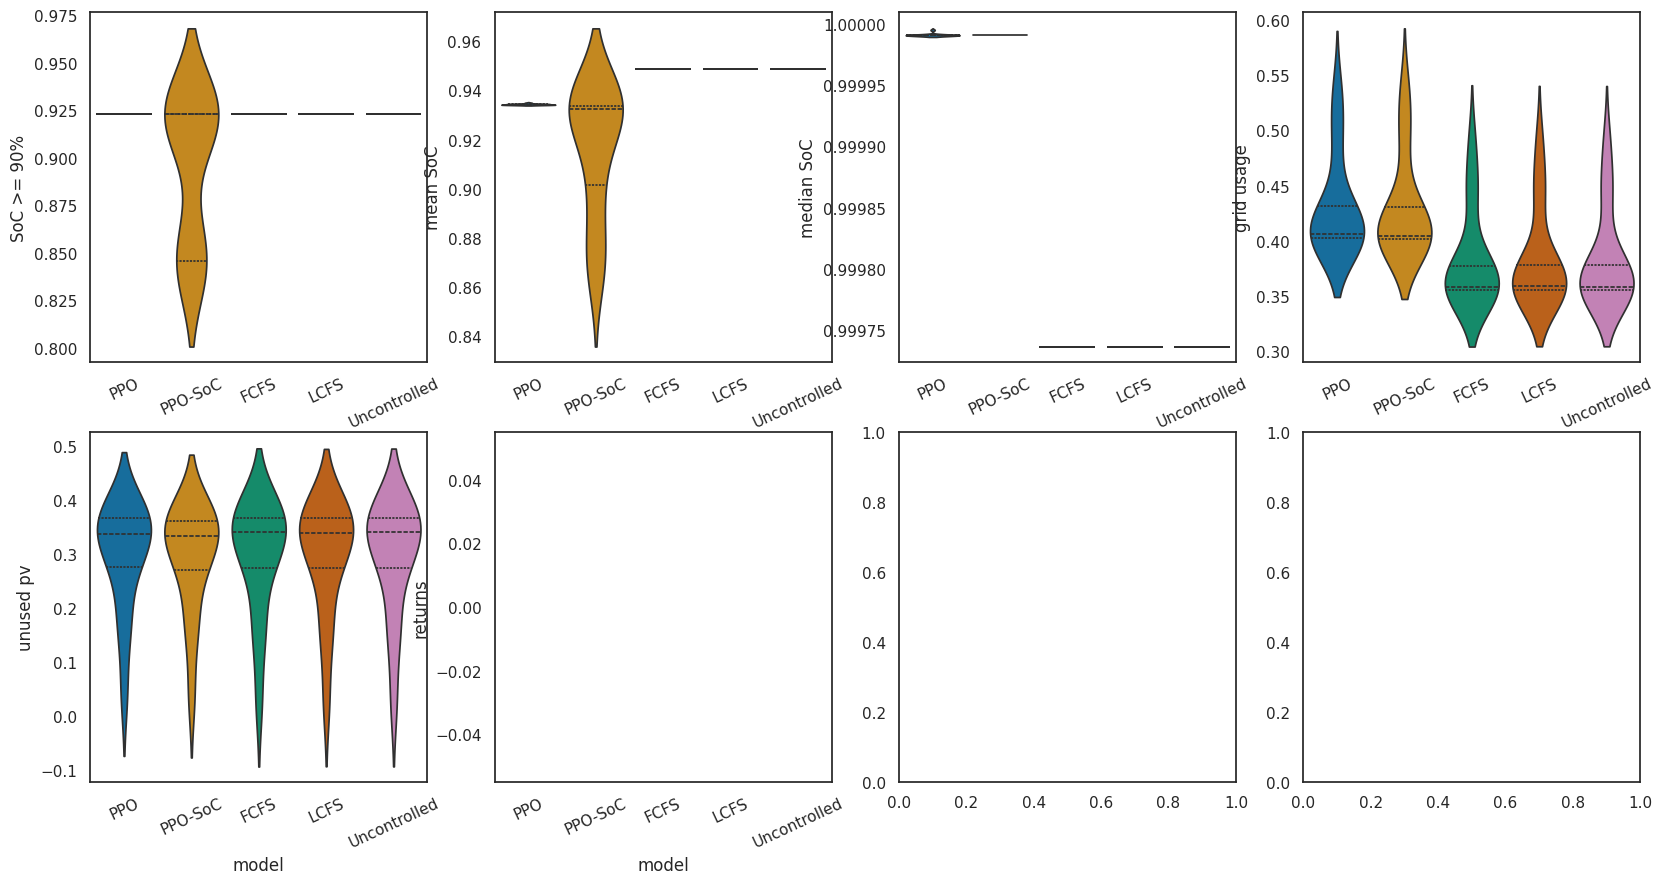

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes_flat = axes.flatten()

for i, (metric_name, statistics) in enumerate(test_statistics.items()):
    ax = axes_flat[i]
    df = pd.DataFrame.from_dict(statistics)
    # Create a violin plot using Seaborn
    sns.violinplot(data=df, inner='quartile', ax=ax)

    # plt.title('Seaborn Violin Plot Example')
    ax.set_xlabel('model')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', labelrotation=25)

In [ ]:
df = pd.DataFrame.from_dict(test_statistics)

for column in df.columns:
    m = np.mean(df[column].tolist(), axis=1)
    s = np.std(df[column].tolist(), axis=1)

    df[column] = [f"{m:.2g} ± {s:.2g}" for m, s in zip(m, s)]

df  # .to_latex()

,SoC >= 90%,mean SoC,median SoC,grid usage,unused pv,returns
PPO,0.92 ± 1.1e-16,0.93 ± 0.00023,1 ± 1.1e-06,0.43 ± 0.044,0.3 ± 0.096,nan ± nan
PPO-SoC,0.9 ± 0.037,0.92 ± 0.026,1 ± 2.2e-16,0.43 ± 0.044,0.29 ± 0.095,nan ± nan
FCFS,0.92 ± 1.1e-16,0.95 ± 0,1 ± 3.3e-16,0.38 ± 0.042,0.29 ± 0.1,nan ± nan
LCFS,0.92 ± 1.1e-16,0.95 ± 3.3e-16,1 ± 3.3e-16,0.38 ± 0.042,0.29 ± 0.1,nan ± nan
Uncontrolled,0.92 ± 1.1e-16,0.95 ± 3.3e-16,1 ± 3.3e-16,0.38 ± 0.042,0.29 ± 0.1,nan ± nan


In [ ]:
alpha_level = 0.01  # used to compare pvalues

def highlight_alpha(styler, caption: str, alpha_level: float):
    # styler.format(lambda pvalue: f"{pvalue:.3g}")
    styler.set_caption(caption)
    styler.map(
        lambda v: "font-weight: bold" if v < alpha_level else "font-weight: normal"
    )
    return styler

In [ ]:
# Perform normality test (Shapiro-Wilk test) https://docs.scipy.org/doc/scipy/tutorial/stats/hypothesis_shapiro.html#hypothesis-shapiro
# "The value of this statistic tends to be high (close to 1) for samples drawn from a normal distribution."
normality_results = defaultdict(lambda: {})
for metric_name, statistics in test_statistics.items():
    for model_name, values in statistics.items():
        shapiro_test = stats.shapiro(values)
        normality_results[metric_name][model_name] = shapiro_test.pvalue

df_normality = pd.DataFrame.from_dict(normality_results)
df_normality.style.pipe(
    lambda s: highlight_alpha(s, "p-values for Shapiro-Wilk test", alpha_level)
)

/tmp/ipykernel_900318/2376808130.py:6: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  shapiro_test = stats.shapiro(values)


,SoC >= 90%,mean SoC,median SoC,grid usage,unused pv,returns
PPO,1.000000,0.003564,0.000000,0.000367,0.002900,1.000000
PPO-SoC,0.000057,0.000403,1.000000,0.000290,0.003105,1.000000
FCFS,1.000000,1.000000,1.000000,0.000252,0.002368,1.000000
LCFS,1.000000,1.000000,1.000000,0.000286,0.002345,1.000000
Uncontrolled,1.000000,1.000000,1.000000,0.000266,0.002345,1.000000


In [ ]:
print(
    df_normality.style.pipe(
        lambda s: highlight_alpha(
            s, "p-values for Shapiro-Wilk test", alpha_level)
    ).to_latex(convert_css=False)
)

\begin{table}
\caption{p-values for Shapiro-Wilk test}
\begin{tabular}{lrrrrrr}
 & SoC >= 90% & mean SoC & median SoC & grid usage & unused pv & returns \\
PPO & \font-weightnormal 1.000000 & \font-weightbold 0.003564 & \font-weightbold 0.000000 & \font-weightbold 0.000367 & \font-weightbold 0.002900 & \font-weightnormal 1.000000 \\
PPO-SoC & \font-weightbold 0.000057 & \font-weightbold 0.000403 & \font-weightnormal 1.000000 & \font-weightbold 0.000290 & \font-weightbold 0.003105 & \font-weightnormal 1.000000 \\
FCFS & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightbold 0.000252 & \font-weightbold 0.002368 & \font-weightnormal 1.000000 \\
LCFS & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightbold 0.000286 & \font-weightbold 0.002345 & \font-weightnormal 1.000000 \\
Uncontrolled & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-weightnormal 1.000000 & \font-wei

In [ ]:
base_model = list(models.keys())[0]

t_test_results = defaultdict(lambda: {})

for metric_name, statistics in test_statistics.items():
    for model_name, values in statistics.items():
        if model_name == base_model:
            continue

        t_test = stats.ttest_ind(
            statistics[base_model],
            values,
        )

        t_test_results[metric_name][model_name] = t_test.pvalue

df_t_test = pd.DataFrame.from_dict(t_test_results)
df_t_test.style.pipe(
    lambda s: highlight_alpha(
        s, f"p-values for independent T-test comparing to {base_model}", alpha_level)
)

/home/guest/tsturm/acn-experiments/.conda/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,SoC >= 90%,mean SoC,median SoC,grid usage,unused pv,returns
PPO-SoC,0.012389,0.013065,0.325641,0.968164,0.913062,nan
FCFS,1.000000,0.000000,0.000000,0.007958,0.963506,nan
LCFS,1.000000,0.000000,0.000000,0.007998,0.955681,nan
Uncontrolled,1.000000,0.000000,0.000000,0.007834,0.962307,nan


In [ ]:
print(
    df_t_test.style.pipe(
        lambda s: highlight_alpha(
            s, f"p-values for independent T-test comparing to {base_model}", alpha_level)
    ).to_latex(convert_css=True)
)

\begin{table}
\caption{p-values for independent T-test comparing to PPO}
\begin{tabular}{lrrrrrr}
 & SoC >= 90% & mean SoC & median SoC & grid usage & unused pv & returns \\
PPO-SoC & 0.012389 & 0.013065 & 0.325641 & 0.968164 & 0.913062 & nan \\
FCFS & 1.000000 & \bfseries 0.000000 & \bfseries 0.000000 & \bfseries 0.007958 & 0.963506 & nan \\
LCFS & 1.000000 & \bfseries 0.000000 & \bfseries 0.000000 & \bfseries 0.007998 & 0.955681 & nan \\
Uncontrolled & 1.000000 & \bfseries 0.000000 & \bfseries 0.000000 & \bfseries 0.007834 & 0.962307 & nan \\
\end{tabular}
\end{table}

